<a href="https://colab.research.google.com/github/AkiHora/Simpsons/blob/main/simpsons_my_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здесь решается задача [конкурса Kaggle](https://www.kaggle.com/c/journey-springfield) в рамках [курса](https://stepik.org/course/50352/info) по компьютерному зрению (2020 г). Решает Еремеев Д. Д.

In [ ]:
import os
import torch

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import classification_report

In [ ]:
# необходимо зайти в аккаунт Google и вставить токен в выпадающее окно
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Далее весь можно запускать весь оставшийся код сразу

In [ ]:
if not os.path.exists('journey-springfield.zip'):
    url = 'https://drive.google.com/file/d/1k-s4J4mxvTIsrOmJUGJiNKxb3Vqt_Ibh/view?usp=sharing'
    downloaded = drive.CreateFile({'id': url.split('/d/')[-1].split('/view')[0]})   # replace the id with id of file you want to access
    downloaded.GetContentFile('journey-springfield.zip')        # replace the file name with your file
    !unzip journey-springfield.zip > /dev/null

In [ ]:
import pickle
import PIL
import numpy as np
import torch.nn as nn
import matplotlib.image as mpimg

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import Counter
from google.colab import files
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
        
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/content/journey-springfield/testset/testset')
'''
АУГМЕНТАЦИЯ ДАННЫХ

Выбирается самый большой класс. Его размер - число max_
Здесь мы берем каждую картинку тренировочного датасета и смотрим, сколько в классе примеров.
Если их меньше, чем max_, то создаем 3 копии этой картинки. 
Одну копию отзеркаливаем и сохраняем как новую.
Вторую поворачиваем по часовой на некоторый небольшой случайный угол и так же сохраняем.
Третью поворачиваем против часовой и сохраняем.
Далее цикл повторяется, пока не обработаем так все [оригинальные] картинки.

Далее мы смотрим на каждый класс.
Если в классе [все еще] меньше картинок, чем max_, то 
добавляем столько копий картинок этого класса, чтобы их кол-во было равно max_.

Таким образом мы делаем аугментацию, максимально сохраняя разнообразие данных.
Наибольший класс самый разнообразный. Те классы, что меньше в < 4 раза 
имеют искаженные копии своих оригинальных картинок, но ни одной одинаковой.
А те, что меньше в > 4 раза пришлось докопировать даже после добавления искажений.
'''
def create_pictures_for_augmentation():
    train_val_files = sorted(list(TRAIN_DIR.rglob('*_????.jpg')))
    parent_names = [train_val_files[i].parent.name for i in range(len(train_val_files))]
    parent_names_dict = Counter(parent_names)
    original_train_val_files = train_val_files

    min_ = max(parent_names_dict.values())
    with tqdm(total=len(original_train_val_files)) as pbar:
        for pic in original_train_val_files:
            if parent_names_dict[pic.parent.name] < min_:
                num = pic.name.split('.jpg')[0].split('pic_')[1]
                if len(num) == 4:
                    im = Image.open(pic)

                    # Отзеркаливание изображения и сохранение как нового 
                    new_image_path = str(pic).replace(num, str(1) + num)
                    if not os.path.exists(new_image_path):
                        im0 = im.transpose(Image.FLIP_LEFT_RIGHT)
                        im0.save(new_image_path)
                    train_val_files.append(Path(new_image_path))

                    # Поворот и сохранение результата
                    new_image_path = str(pic).replace(num, str(2) + num)
                    if not os.path.exists(new_image_path):
                        random_angle = int(np.random.uniform(-10, 10))
                        im1 = im.rotate(20 + random_angle)
                        im1.save(new_image_path)
                    train_val_files.append(Path(new_image_path))

                    # Поворот в другую сторону и сохранение результата
                    new_image_path = str(pic).replace(num, str(3) + num)
                    if not os.path.exists(new_image_path):
                        random_angle = int(np.random.uniform(-10, 10))
                        im2 = im.rotate(-20 + random_angle)
                        im2.save(new_image_path)
                    train_val_files.append(Path(new_image_path))

                    parent_names_dict[pic.parent.name] += 3
            pbar.update()

In [ ]:
import random

def get_augmented_files(train_files, min_ = None, max_ = None):
    parent_names = [train_files[i].parent.name for i in range(len(train_files))]
    parent_names_dict = Counter(parent_names)
    if max_ == None:
        max_ = max(parent_names_dict.values())
    if min_ == None:
        min_ = max_

    extra_pic = sorted(list(TRAIN_DIR.rglob('*_?????.jpg')))

    train_files_original = train_files

    with tqdm(total=len(train_files_original)) as pbar:
        for pic in train_files_original:
            if parent_names_dict[pic.parent.name] < min_:
                num = pic.name.split('.jpg')[0].split('pic_')[1]
                if len(num) == 4:
                    for i in range(1, 4):
                        new_path = Path(str(pic).replace(num, str(i) + num))
                        if os.path.exists(new_path):
                            train_files.append(Path(new_path))
                            parent_names_dict[pic.parent.name] += 1
                        else:
                            break

            pbar.update()


    parent_names = [train_files[i].parent.name for i in range(len(train_files))]
    parent_names_dict = Counter(parent_names)

    with tqdm(total=len(np.unique(parent_names))) as pbar:
        for name in np.unique(parent_names):
            if parent_names_dict[name] < min_:
                this_name_files = []
                for path in train_files:
                    if name in path.parent.name:
                        this_name_files.append(path)
            
                stock = parent_names_dict[name]
                factor = int(min_ / stock) - 1
                residue = min_ % stock

                train_files.extend(this_name_files*factor)
                train_files.extend(this_name_files[:residue])
            pbar.update()
    return train_files

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_val_files = sorted(list(TRAIN_DIR.rglob('*_????.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, shuffle=True)

In [ ]:
# аугментация датасета
create_pictures_for_augmentation()

46349it [00:02, 20382.67it/s]


In [ ]:
'''
Код на случай, если надо сократить обучающую выборку, 
оставив конкретные классы. На полной выборке обучение длится часы. 
Если выбрать некоторых персонажей (например, comic_book_guy, 
nelson_muntz и edna_krabappel), то время обучения сокращается до нескольких минут.
'''
# --------------------------------------
some_simpsons = ['comic_book_guy', 'nelson_muntz', 'edna_krabappel']

def choose_some_simpsons(files, some_simpsons):
    some_files = []
    for i in range(len(files)):
        if files[i].parent.name in some_simpsons:
            some_files.append(files[i])
    return some_files

train_files = choose_some_simpsons(train_files, some_simpsons)
val_files = choose_some_simpsons(val_files, some_simpsons)
# --------------------------------------

In [ ]:
parent_names = [train_files[i].parent.name for i in range(len(train_files))]
parent_names = Counter(parent_names)
parent_names

Counter({'comic_book_guy': 352, 'edna_krabappel': 343, 'nelson_muntz': 269})

In [ ]:
random.shuffle(train_val_files)
'''
Есть два варианта обучения: 
1. обучение на 100% предоставленных данных (то есть из папки train)
2. обучение на 75% предоставленных данных, 
остальное оставлем для тестирования

1-й вариант для конкурса (тестирование происходит на картинках из папки testset).
То есть как бы обучение вслепую (пока не отправим результат на конкурс)
2-й вариант для эксперементов. Результат будет, естесственно, похуже, 
но мы сможем в процессе обучения его видеть

Для выбора варианта обучения нужно закомментировать ненужный
'''

# 1 вариант:
# train_files = get_augmented_files(train_val_files)

# 2 вариант:
train_files = get_augmented_files(train_files)

parent_names = [train_files[i].parent.name for i in range(len(train_files))]
parent_names = Counter(parent_names)
parent_names

1057it [00:00, 127132.92it/s]          
100%|██████████| 3/3 [00:00<00:00, 1648.06it/s]


Counter({'comic_book_guy': 352, 'edna_krabappel': 352, 'nelson_muntz': 353})

In [ ]:
random.shuffle(train_files)
random.shuffle(val_files)
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

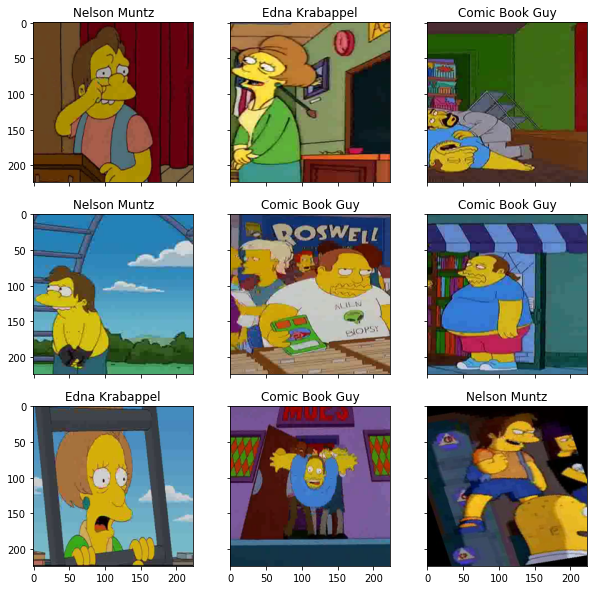

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = criterion(outputs, labels).to(DEVICE)

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    
    return val_loss, val_acc

import sys, os
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    with tqdm(total=len(train_loader)) as pbar:
        for inputs, labels in train_loader:
            model.train(True)

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            model.train(False)

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
            pbar.update()
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

def train(train_dataset, val_files, model, epochs, batch_size, history, lr=0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    print("\nEpoch  train_loss  val_loss  train_acc  val_acc")

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        print("    {}      {:.4f}    {:.4f}     {:.4f}   {:.4f}".format(epoch+1, train_loss, val_loss, train_acc, val_acc))
        '''
        вследствии нестабильности инициализации нейросети и обучения (переполнения 
        памяти cuda, внезапные блокировки cuda colabом и прочие неприятности)
        будем сохранять модель каждую эпоху
        '''
        torch.save(model, 'model')

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


In [ ]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'D':
            layers += [nn.Dropout2d(0.6)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=False)]
            else:
                layers += [conv2d, nn.ReLU(inplace=False)]
            in_channels = v
            
    return nn.Sequential(*layers)

class SimpleCnn(nn.Module):
    def __init__(self, n_classes, cfg):
        super().__init__()
        self.layers = make_layers(cfg, batch_norm=True)

        train_l = DataLoader(train_dataset, batch_size=3, shuffle=True)
        pred = self.layers(next(iter(train_l))[0])
        inline_size = pred.view(pred.size(0), -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(inline_size, 4096),

            # nn.ReLU(True),
            # nn.Dropout(),
            # nn.Linear(4096, 4096),

            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, n_classes),

            # nn.Linear(inline_size, n_classes),
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)

        return logits

In [ ]:
'''
Тут можно выбать конфигурацию сети
'''
cfgs = {
    # для экспериментов с 6 классами (в % указана accuracy):
    'A': [32, 'M', 64, 'D', 64, 'M', 128, 'M', 'D'], # max: ~87 %
    'B': [32, 32, 'M', 64, 64, 'M', 128, 128, 'M',  ], # max: ~89 %
    'C': [32, 'M', 64, 64, 'M', 128, 128, 'M', 256, 'M', ], # max: ~87 % + 6% аугментация отзеркаливание и поворот 

    # для 42 классов:
    'a': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # max ~90% 
    'b': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 'D', 512, 512, 'M', 'D', 512, 512, 'M',],
    'c': [64, 64, 'M', 128, 128, 'M', 'D', 256, 256, 'M', 'D', 512, 'M', 'D', 512, 'M',],

}
DEVICE = torch.device("cuda:0")
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, cfgs['b'])
simple_cnn = simple_cnn.to(DEVICE)

print("we will classify: {}".format(n_classes))
print(simple_cnn)

we will classify: 42
SimpleCnn(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), s

In [ ]:
'''
Здесь модель обучается.
batch_size=70. Лучше, наверное, больше, но при большем батче у cuda 
с большим шансом нехватит памяти, и все придется качать и запускать с нуля.
'''

history = []
train(train_dataset, val_dataset, model=simple_cnn, epochs=1, batch_size=70, history=history, lr=0.001)

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch  train_loss  val_loss  train_acc  val_acc


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


    1      20.2211    181.2980     0.3860   0.4188


In [ ]:
train(train_dataset, val_dataset, model=simple_cnn, epochs=9, batch_size=70, history=history, lr=0.001)

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch  train_loss  val_loss  train_acc  val_acc


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


    1      15.3050    5.1058     0.3633   0.5094


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


    2      3.3777    2.7867     0.4588   0.5281


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


    3      1.7244    1.5701     0.5676   0.6656


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


    4      1.0580    1.2897     0.6026   0.5406


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


    5      0.9675    0.8517     0.5733   0.6250


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


    6      0.7522    0.7052     0.6462   0.7688


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


    7      0.7919    0.7763     0.7247   0.6281


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


    8      1.7787    1.2000     0.6254   0.6594


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


    9      0.9455    0.7279     0.6802   0.8063


In [ ]:
'''
В этой ячейке модель делает предсказания персонажей тестовой выборки (из папки journey-springfield/testset).
Ответы записываются в файл submission.csv по шаблону, требуемому в конкурсе.
'''

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = []
with tqdm(total=len(test_loader)) as pbar:
    for inputs in test_loader:
        preds.append(predict_one_sample(simple_cnn, inputs)[0])
        pbar.update()
preds = np.argmax(preds,-1)
preds_class = [label_encoder.classes_[i] for i in preds]

with open('submission.csv', 'w') as f:
    f.write('Id,Expected\n')
    for file, pred in zip(test_files, preds_class):
        f.write('{},{}\n'.format(file.name, pred))

100%|██████████| 991/991 [00:08<00:00, 123.09it/s]


In [ ]:
# вывод результатов предсказания на валидации (presition, recall, f-мера )
imgs = [val_dataset[i][0].unsqueeze(0) for i in range(len(val_files))]
preds = predict(simple_cnn, imgs).argmax(axis=1)
preds_class = [label_encoder.classes_[i] for i in preds]
y = [val_dataset[i][1] for i in range(len(val_files))]
y = [label_encoder.classes_[i] for i in y]
print(classification_report(y, preds_class))

                precision    recall  f1-score   support

comic_book_guy       0.89      0.79      0.84       117
edna_krabappel       0.90      0.79      0.84       114
  nelson_muntz       0.65      0.84      0.73        89

      accuracy                           0.81       320
     macro avg       0.81      0.81      0.80       320
  weighted avg       0.83      0.81      0.81       320



Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

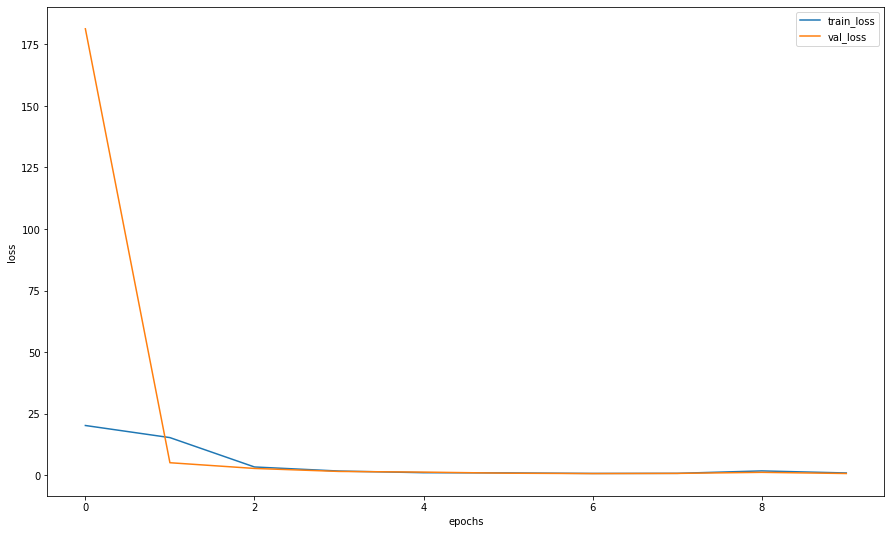

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

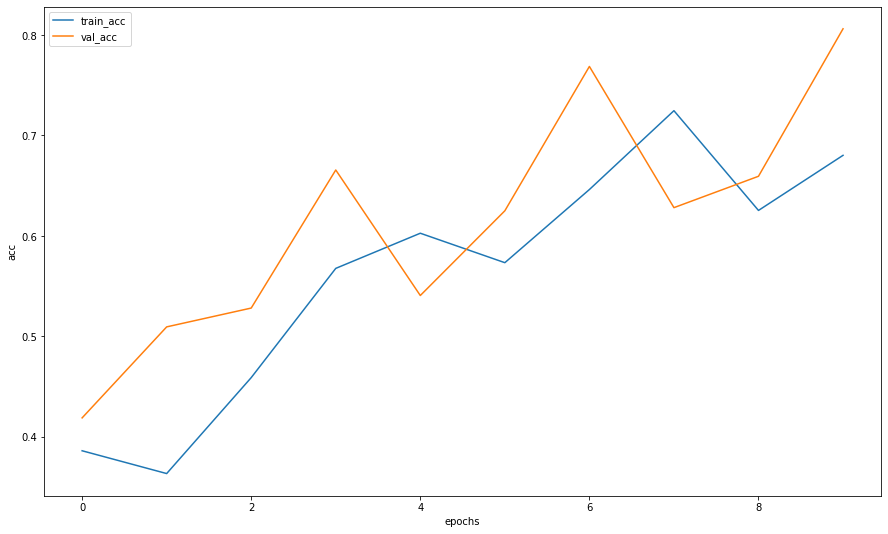

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
'''
Здесь можно посмотреть на уверенность модели в предсказании случайных картинок
валидационного датасета.
'''

random_characters = int(np.random.uniform(0,100))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

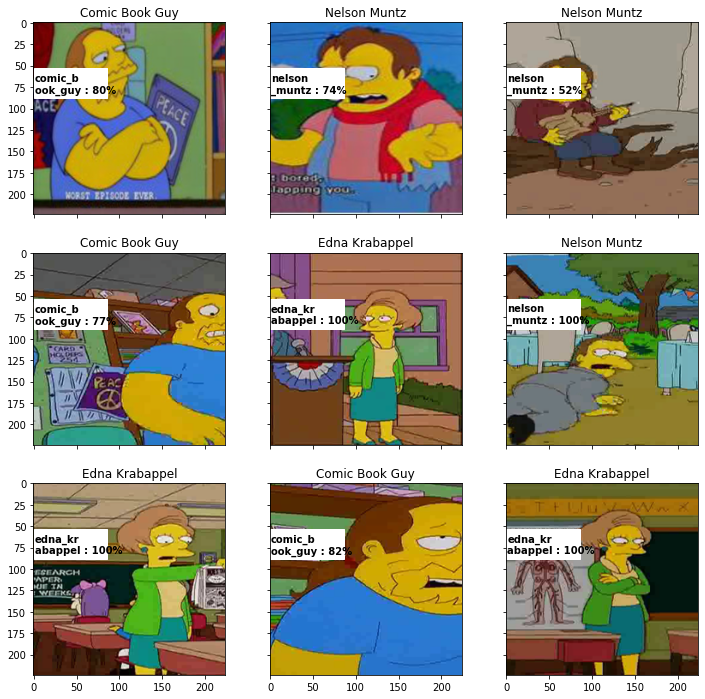

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', #fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')